**[Colab](https://colab.research.google.com/drive/1z84tpzrAi6oMiFSr06yy_pmJ9Dqi8vyX?usp=sharing)**

# Установка библиотек

In [1]:
!pip install -q xgboost lightgbm catboost shap optuna scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.7 MB/s eta 0:00:00


# Импорт библиотек

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler
import time
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', font_scale=1.1)

# Загрузка и подготовка данных

In [2]:
data = pd.read_csv('financials.csv', sep=',')

# Создание новых финансовых признаков
data['Earnings'] = data['Price'] / data['Price/Earnings']
data['Sales'] = data['Price'] / data['Price/Sales']
data['Book'] = data['Price'] / data['Price/Book']

# Удаление ненужных столбцов
df = data.drop(['Symbol', 'Name', 'SEC Filings', 'Price', 'Price/Earnings', 'Price/Sales', 'Price/Book'], axis=1)


# Предобработка данных

In [3]:
X = df.drop('Market Cap', axis=1)
y = df['Market Cap']

categorical_features = ['Sector']
numerical_features = X.drop('Sector', axis=1).columns.tolist()

def create_preprocessor():
    return ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler())
            ]), numerical_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ],
        remainder='drop'
    )


# Функция логарифмического преобразования

In [4]:
def prepare_data(X, y, log_features=False, log_target=False):
    X_copy = X.copy()
    y_copy = y.copy()

    if log_features:
        for col in numerical_features:
            if (X_copy[col] <= 0).any():
                X_copy[col] = np.log1p(X_copy[col].abs())
            else:
                X_copy[col] = np.log1p(X_copy[col])

    if log_target:
        if (y_copy <= 0).any():
            y_copy = np.log1p(y_copy.abs())
        else:
            y_copy = np.log1p(y_copy)

    return X_copy, y_copy

# Функция подбора гиперпараметров для базовых моделей с использованием Optuna


In [5]:
def optimize_base_models(X_train, y_train, log_features=False, log_target=False, n_trials=50):
    """
    Оптимизация гиперпараметров для базовых моделей с использованием Optuna
    """
    print(f"\n{'='*70}")
    print(f"ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ С OPTUNA (лог_признаки={log_features}, лог_цель={log_target})")
    print(f"{'='*70}")

    # Подготовка данных
    X_train_prep, y_train_prep = prepare_data(X_train, y_train, log_features, log_target)

    # Создание предобработчика
    preprocessor = create_preprocessor()

    best_models = {}
    best_params = {}
    best_scores = {}

    # Общие параметры для Optuna
    common_params = {
        'sampler': TPESampler(seed=42),
        'pruner': HyperbandPruner(min_resource=1, max_resource=5, reduction_factor=3)
    }

    # 1. Ridge Regression
    print("\nОптимизация Ridge Regression с Optuna")

    def ridge_objective(trial):
        # Определение гиперпараметров для поиска
        alpha = trial.suggest_float('alpha', 1e-4, 100, log=True)

        # Создание модели
        model = Ridge(alpha=alpha, random_state=42)

        # Создание pipeline с предобработкой
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Кросс-валидация
        score = cross_val_score(pipeline, X_train_prep, y_train_prep, cv=3, scoring='r2', n_jobs=-1).mean()

        return score

    # Запуск оптимизации
    ridge_study = optuna.create_study(direction='maximize', **common_params)
    ridge_study.optimize(ridge_objective, n_trials=n_trials//3, show_progress_bar=True)  # Меньше итераций для простой модели

    # Сохранение результатов
    best_ridge = Ridge(**ridge_study.best_params, random_state=42)
    best_models['ridge'] = best_ridge
    best_params['ridge'] = ridge_study.best_params
    best_scores['ridge'] = ridge_study.best_value
    print(f"Ridge R²: {ridge_study.best_value:.4f}, Параметры: {ridge_study.best_params}")

    # 2. Random Forest
    print("\nОптимизация Random Forest с Optuna")

    def rf_objective(trial):
        # Определение гиперпараметров
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        }

        # Создание модели
        model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)

        # Pipeline с предобработкой
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        return cross_val_score(pipeline, X_train_prep, y_train_prep, cv=3, scoring='r2', n_jobs=-1).mean()

    # Оптимизация
    rf_study = optuna.create_study(direction='maximize', **common_params)
    rf_study.optimize(rf_objective, n_trials=n_trials, show_progress_bar=True)

    # Сохранение результатов
    best_rf = RandomForestRegressor(**rf_study.best_params, random_state=42, n_jobs=-1)
    best_models['rf'] = best_rf
    best_params['rf'] = rf_study.best_params
    best_scores['rf'] = rf_study.best_value
    print(f"RF R²: {rf_study.best_value:.4f}, Параметры: {rf_study.best_params}")

    # 3. XGBoost
    print("\nОптимизация XGBoost с Optuna")

    def xgb_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'alpha': trial.suggest_float('alpha', 1e-8, 10, log=True),
            'lambda': trial.suggest_float('lambda', 1e-8, 10, log=True)
        }

        model = XGBRegressor(**params, random_state=42, n_jobs=-1, verbosity=0)
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        return cross_val_score(pipeline, X_train_prep, y_train_prep, cv=3, scoring='r2', n_jobs=-1).mean()

    xgb_study = optuna.create_study(direction='maximize', **common_params)
    xgb_study.optimize(xgb_objective, n_trials=n_trials, show_progress_bar=True)

    best_xgb = XGBRegressor(**xgb_study.best_params, random_state=42, n_jobs=-1, verbosity=0)
    best_models['xgb'] = best_xgb
    best_params['xgb'] = xgb_study.best_params
    best_scores['xgb'] = xgb_study.best_value
    print(f"XGB R²: {xgb_study.best_value:.4f}, Параметры: {xgb_study.best_params}")

    # 4. LightGBM
    print("\nОптимизация LightGBM с Optuna")

    def lgbm_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 15, 128),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True)
        }

        model = LGBMRegressor(**params, random_state=42, n_jobs=-1, verbose=-1)
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        return cross_val_score(pipeline, X_train_prep, y_train_prep, cv=3, scoring='r2', n_jobs=-1).mean()

    lgbm_study = optuna.create_study(direction='maximize', **common_params)
    lgbm_study.optimize(lgbm_objective, n_trials=n_trials, show_progress_bar=True)

    best_lgbm = LGBMRegressor(**lgbm_study.best_params, random_state=42, n_jobs=-1, verbose=-1)
    best_models['lgbm'] = best_lgbm
    best_params['lgbm'] = lgbm_study.best_params
    best_scores['lgbm'] = lgbm_study.best_value
    print(f"LGBM R²: {lgbm_study.best_value:.4f}, Параметры: {lgbm_study.best_params}")

    # 5. CatBoost
    print("\nОптимизация CatBoost с Optuna")

    def cat_objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 50, 300),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'depth': trial.suggest_int('depth', 3, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10, log=True),
            'border_count': trial.suggest_int('border_count', 32, 255)
        }

        model = CatBoostRegressor(**params, random_state=42, verbose=0, thread_count=-1)
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        return cross_val_score(pipeline, X_train_prep, y_train_prep, cv=3, scoring='r2').mean()

    cat_study = optuna.create_study(direction='maximize', **common_params)
    cat_study.optimize(cat_objective, n_trials=n_trials, show_progress_bar=True)

    best_cat = CatBoostRegressor(**cat_study.best_params, random_state=42, verbose=0, thread_count=-1)
    best_models['cat'] = best_cat
    best_params['cat'] = cat_study.best_params
    best_scores['cat'] = cat_study.best_value
    print(f"CatBoost R²: {cat_study.best_value:.4f}, Параметры: {cat_study.best_params}")

    return best_models, best_params, best_scores

# Обучение и оценка для одного сценария с оптимизацией


In [6]:
def train_evaluate_with_optimization(log_features=False, log_target=False, model_name=""):
    """Обучает и оценивает стекинг для одного сценария с оптимизацией гиперпараметров через Optuna"""
    print(f"\n{'='*80}")
    print(f"СЦЕНАРИЙ: {model_name}")
    print(f"Лог_признаки={log_features}, Лог_цель={log_target}")
    print(f"{'='*80}")

    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Оптимизация гиперпараметров
    start_opt_time = time.time()
    best_models, best_params, best_scores = optimize_base_models(
        X_train, y_train, log_features, log_target, n_trials=50  # Уменьшаем количество итераций для Colab
    )
    opt_time = time.time() - start_opt_time
    print(f"\nВремя оптимизации гиперпараметров: {opt_time/60:.2f} минут")

    # Подготовка данных
    X_train_prep, y_train_prep = prepare_data(X_train, y_train, log_features, log_target)
    X_test_prep, y_test_prep = prepare_data(X_test, y_test, log_features, log_target)

    # Создание стекинга
    stacking_estimators = [(name, model) for name, model in best_models.items()]
    stacking = StackingRegressor(
        estimators=stacking_estimators,
        final_estimator=LinearRegression(n_jobs=-1),
        n_jobs=-1,
        cv=5,
        passthrough=False
    )

    # Пайплайн с предобработкой
    pipeline = Pipeline([
        ('preprocessor', create_preprocessor()),
        ('regressor', stacking)
    ])

    # Обучение
    start_time = time.time()
    pipeline.fit(X_train_prep, y_train_prep)
    fit_time = time.time() - start_time

    # Предсказания
    y_pred = pipeline.predict(X_test_prep)

    # Обратное преобразование для логарифмированной целевой переменной
    if log_target:
        y_test_orig = np.expm1(y_test_prep)
        y_pred_orig = np.expm1(y_pred)
    else:
        y_test_orig = y_test_prep
        y_pred_orig = y_pred

    # Расчет метрик
    r2 = r2_score(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mape = np.mean(np.abs((y_test_orig - y_pred_orig) / np.maximum(y_test_orig, 1e-6))) * 100

    print(f"\nСтекинг обучен за {fit_time:.2f} секунд")
    print(f"Метрики на тестовых данных:")
    print(f"   R²: {r2:.4f}")
    print(f"   RMSE: {rmse:,.0f}")
    print(f"   MAE: {mae:,.0f}")
    print(f"   MAPE: {mape:.2f}%")

    return {
        'pipeline': pipeline,
        'metrics': {
            'R2_test': r2,
            'RMSE_test': rmse,
            'MAE_test': mae,
            'MAPE_test': mape,
            'Fit_time_sec': fit_time,
            'Opt_time_min': opt_time/60
        },
        'best_params': best_params,
        'best_scores': best_scores,
        'y_test_orig': y_test_orig,
        'y_pred_orig': y_pred_orig,
        'log_features': log_features,
        'log_target': log_target,
        'model_name': model_name
    }

# Цикл по всем трем сценариям


In [7]:
scenarios = [
    {"log_features": False, "log_target": False, "name": "1. Оригинальный датасет"},
    {"log_features": False, "log_target": True, "name": "2. Логарифмированная целевая переменная"},
    {"log_features": True, "log_target": True, "name": "3. Логарифмированные признаки и целевая переменная"}
]

all_results = []

for scenario in scenarios:
    result = train_evaluate_with_optimization(
        log_features=scenario["log_features"],
        log_target=scenario["log_target"],
        model_name=scenario["name"]
    )

    # Добавляем кросс-валидацию для финальной модели
    print(f"\nВычисление среднего R² через кросс-валидацию")
    start_time = time.time()

    # Получаем данные в нужном формате
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_prep, y_train_prep = prepare_data(X_train, y_train,
                                             scenario["log_features"],
                                             scenario["log_target"])

    # Выполняем кросс-валидацию
    cv_scores = cross_val_score(
        result['pipeline'],
        X_train_prep,
        y_train_prep,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    cv_time = time.time() - start_time
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    print(f"Кросс-валидация выполнена за {cv_time:.2f} секунд")
    print(f"Среднее R² (CV): {cv_mean:.4f} ± {cv_std:.4f}")
    print(f"R² по фолдам: {[f'{score:.4f}' for score in cv_scores]}")

    # Добавляем метрики кросс-валидации в результат
    result['metrics']['R2_CV_mean'] = cv_mean
    result['metrics']['R2_CV_std'] = cv_std
    all_results.append(result)

[I 2025-12-20 18:29:19,395] A new study created in memory with name: no-name-9b010fc7-b89a-45b0-b3f2-ddb66f0cdd48



СЦЕНАРИЙ: 1. Оригинальный датасет
Лог_признаки=False, Лог_цель=False

ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ С OPTUNA (лог_признаки=False, лог_цель=False)

Оптимизация Ridge Regression с Optuna


  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-20 18:29:25,501] Trial 0 finished with value: 0.6736443663016907 and parameters: {'alpha': 0.017670169402947963}. Best is trial 0 with value: 0.6736443663016907.
[I 2025-12-20 18:29:28,490] Trial 1 finished with value: 0.6539797296055737 and parameters: {'alpha': 50.61576888752309}. Best is trial 0 with value: 0.6736443663016907.
[I 2025-12-20 18:29:28,550] Trial 2 finished with value: 0.6606447571640705 and parameters: {'alpha': 2.465832945854912}. Best is trial 0 with value: 0.6736443663016907.
[I 2025-12-20 18:29:28,593] Trial 3 finished with value: 0.6731107478640954 and parameters: {'alpha': 0.39079671568228835}. Best is trial 0 with value: 0.6736443663016907.
[I 2025-12-20 18:29:28,655] Trial 4 finished with value: 0.6735087529831406 and parameters: {'alpha': 0.0008632008168602544}. Best is trial 0 with value: 0.6736443663016907.
[I 2025-12-20 18:29:28,708] Trial 5 finished with value: 0.6735087504511439 and parameters: {'alpha': 0.0008629132190071859}. Best is trial 0

[I 2025-12-20 18:29:29,384] A new study created in memory with name: no-name-63b1fea8-d988-47c0-a261-0637835eecbe


[I 2025-12-20 18:29:29,203] Trial 12 finished with value: 0.673610809297788 and parameters: {'alpha': 0.013219865815104105}. Best is trial 11 with value: 0.6736496280930052.
[I 2025-12-20 18:29:29,253] Trial 13 finished with value: 0.6736985095460214 and parameters: {'alpha': 0.025356922136198324}. Best is trial 13 with value: 0.6736985095460214.
[I 2025-12-20 18:29:29,318] Trial 14 finished with value: 0.6739279679806017 and parameters: {'alpha': 0.07043145059886571}. Best is trial 14 with value: 0.6739279679806017.
[I 2025-12-20 18:29:29,378] Trial 15 finished with value: 0.6740226288334523 and parameters: {'alpha': 0.10910745683661212}. Best is trial 15 with value: 0.6740226288334523.
Ridge R²: 0.6740, Параметры: {'alpha': 0.10910745683661212}

Оптимизация Random Forest с Optuna


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-20 18:29:29,830] Trial 0 finished with value: 0.46048081977805017 and parameters: {'n_estimators': 53, 'max_depth': 15, 'min_samples_split': 17, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.46048081977805017.
[I 2025-12-20 18:29:30,174] Trial 1 finished with value: 0.4506389203845817 and parameters: {'n_estimators': 77, 'max_depth': 6, 'min_samples_split': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.46048081977805017.
[I 2025-12-20 18:29:30,743] Trial 2 finished with value: 0.44797128983725293 and parameters: {'n_estimators': 142, 'max_depth': 4, 'min_samples_split': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.46048081977805017.
[I 2025-12-20 18:29:31,225] Trial 3 finished with value: 0.4610842910657988 and parameters: {'n_estimators': 168, 'max_depth': 5, 'min_samples_split': 11, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.4610842910657988.
[I 2025-12-20 18:29:31,682] Trial 4 finished with value: 0.47237071768339806 and para

[I 2025-12-20 18:29:54,215] A new study created in memory with name: no-name-60756267-bd05-4886-bff2-a5c5845f0080


[I 2025-12-20 18:29:54,213] Trial 49 finished with value: 0.4212278689367521 and parameters: {'n_estimators': 142, 'max_depth': 3, 'min_samples_split': 5, 'max_features': 'log2'}. Best is trial 33 with value: 0.5290851606321775.
RF R²: 0.5291, Параметры: {'n_estimators': 133, 'max_depth': 15, 'min_samples_split': 4, 'max_features': 'log2'}

Оптимизация XGBoost с Optuna


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-20 18:29:54,918] Trial 0 finished with value: 0.5247552851199303 and parameters: {'n_estimators': 147, 'max_depth': 5, 'learning_rate': 0.11294923622078903, 'subsample': 0.6783766633467947, 'colsample_bytree': 0.6404672548436904, 'alpha': 0.0007660634613082914, 'lambda': 1.8548894229694903e-07}. Best is trial 0 with value: 0.5247552851199303.
[I 2025-12-20 18:29:55,320] Trial 1 finished with value: 0.48401116442847875 and parameters: {'n_estimators': 251, 'max_depth': 3, 'learning_rate': 0.27838036931305016, 'subsample': 0.8861223846483287, 'colsample_bytree': 0.5993578407670862, 'alpha': 1.1212412169964432e-08, 'lambda': 0.2183498289760726}. Best is trial 0 with value: 0.5247552851199303.
[I 2025-12-20 18:29:56,093] Trial 2 finished with value: 0.6074210439551303 and parameters: {'n_estimators': 227, 'max_depth': 8, 'learning_rate': 0.08138233922650512, 'subsample': 0.5370223258670452, 'colsample_bytree': 0.6792328642721364, 'alpha': 1.1036250149900698e-07, 'lambda': 0.5860

[I 2025-12-20 18:30:28,714] A new study created in memory with name: no-name-4057bbba-e586-423e-9454-566fb4979a8e


[I 2025-12-20 18:30:28,712] Trial 49 finished with value: 0.5796237960651559 and parameters: {'n_estimators': 263, 'max_depth': 3, 'learning_rate': 0.018660135100710754, 'subsample': 0.7880127401290065, 'colsample_bytree': 0.5425623164068268, 'alpha': 9.574797969466394, 'lambda': 0.0358922521909123}. Best is trial 38 with value: 0.6420753822882447.
XGB R²: 0.6421, Параметры: {'n_estimators': 248, 'max_depth': 3, 'learning_rate': 0.03095571211256632, 'subsample': 0.8373795801742535, 'colsample_bytree': 0.7663194986728605, 'alpha': 0.006919132409408857, 'lambda': 3.3191058634338044}

Оптимизация LightGBM с Optuna


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-20 18:30:29,791] Trial 0 finished with value: 0.2844836792706665 and parameters: {'n_estimators': 154, 'learning_rate': 0.0035496699837680888, 'num_leaves': 28, 'max_depth': 5, 'subsample': 0.9714548519562596, 'colsample_bytree': 0.6616014660103776, 'reg_alpha': 0.0004667836070663388, 'reg_lambda': 0.02124078827890451}. Best is trial 0 with value: 0.2844836792706665.
[I 2025-12-20 18:30:30,394] Trial 1 finished with value: 0.21974436657573582 and parameters: {'n_estimators': 141, 'learning_rate': 0.2554006816661351, 'num_leaves': 124, 'max_depth': 5, 'subsample': 0.7486242529461927, 'colsample_bytree': 0.6504391549083848, 'reg_alpha': 3.660702614351293e-06, 'reg_lambda': 2.147744058054667e-08}. Best is trial 0 with value: 0.2844836792706665.
[I 2025-12-20 18:30:30,675] Trial 2 finished with value: 0.46539617729748284 and parameters: {'n_estimators': 203, 'learning_rate': 0.01758720770925141, 'num_leaves': 20, 'max_depth': 5, 'subsample': 0.9541329429833268, 'colsample_bytree

[I 2025-12-20 18:30:51,132] A new study created in memory with name: no-name-b751e9da-0237-46b0-a371-5ab7fbf1e973


[I 2025-12-20 18:30:51,115] Trial 49 finished with value: 0.43221836271044506 and parameters: {'n_estimators': 284, 'learning_rate': 0.029269679840315418, 'num_leaves': 38, 'max_depth': 7, 'subsample': 0.788609337279661, 'colsample_bytree': 0.5202496076947741, 'reg_alpha': 0.016948332272446447, 'reg_lambda': 1.5892637309700084e-07}. Best is trial 45 with value: 0.470357090515335.
LGBM R²: 0.4704, Параметры: {'n_estimators': 146, 'learning_rate': 0.030837441341798152, 'num_leaves': 89, 'max_depth': 3, 'subsample': 0.6400202150995056, 'colsample_bytree': 0.5273607416378542, 'reg_alpha': 0.0024748821734393556, 'reg_lambda': 8.192752190631691e-07}

Оптимизация CatBoost с Optuna


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-20 18:31:00,719] Trial 0 finished with value: 0.6113161192203457 and parameters: {'iterations': 187, 'learning_rate': 0.051749755262040925, 'depth': 8, 'l2_leaf_reg': 1.043335020558628e-06, 'border_count': 191}. Best is trial 0 with value: 0.6113161192203457.
[I 2025-12-20 18:31:10,188] Trial 1 finished with value: 0.3926879635185145 and parameters: {'iterations': 109, 'learning_rate': 0.006398151340670027, 'depth': 8, 'l2_leaf_reg': 0.007025804993039185, 'border_count': 222}. Best is trial 0 with value: 0.6113161192203457.
[I 2025-12-20 18:31:11,682] Trial 2 finished with value: 0.6472062692017269 and parameters: {'iterations': 215, 'learning_rate': 0.02557227231759421, 'depth': 3, 'l2_leaf_reg': 2.0391173859019014e-05, 'border_count': 91}. Best is trial 2 with value: 0.6472062692017269.
[I 2025-12-20 18:31:13,762] Trial 3 finished with value: 0.6495403534819156 and parameters: {'iterations': 111, 'learning_rate': 0.25719654260941993, 'depth': 6, 'l2_leaf_reg': 1.0676256433

[I 2025-12-20 18:33:34,014] A new study created in memory with name: no-name-b8ffe386-2d95-46b5-8da6-d2722891caed


Кросс-валидация выполнена за 16.37 секунд
Среднее R² (CV): 0.4629 ± 0.3079
R² по фолдам: ['0.6879', '0.4092', '0.8729', '0.3762', '-0.0319']

СЦЕНАРИЙ: 2. Логарифмированная целевая переменная
Лог_признаки=False, Лог_цель=True

ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ С OPTUNA (лог_признаки=False, лог_цель=True)

Оптимизация Ridge Regression с Optuna


  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-20 18:33:34,397] Trial 0 finished with value: 0.3957954035202061 and parameters: {'alpha': 0.017670169402947963}. Best is trial 0 with value: 0.3957954035202061.
[I 2025-12-20 18:33:34,636] Trial 1 finished with value: 0.3910876670160355 and parameters: {'alpha': 50.61576888752309}. Best is trial 0 with value: 0.3957954035202061.
[I 2025-12-20 18:33:34,723] Trial 2 finished with value: 0.3936887355690482 and parameters: {'alpha': 2.465832945854912}. Best is trial 0 with value: 0.3957954035202061.
[I 2025-12-20 18:33:34,775] Trial 3 finished with value: 0.3962841056614512 and parameters: {'alpha': 0.39079671568228835}. Best is trial 3 with value: 0.3962841056614512.
[I 2025-12-20 18:33:34,838] Trial 4 finished with value: 0.3957128932505099 and parameters: {'alpha': 0.0008632008168602544}. Best is trial 3 with value: 0.3962841056614512.
[I 2025-12-20 18:33:34,894] Trial 5 finished with value: 0.395712891761897 and parameters: {'alpha': 0.0008629132190071859}. Best is trial 3 

[I 2025-12-20 18:33:35,523] A new study created in memory with name: no-name-4e571fc5-45eb-4f18-b938-64f9698648f6


[I 2025-12-20 18:33:35,385] Trial 12 finished with value: 0.39618336150419564 and parameters: {'alpha': 0.14247594507241243}. Best is trial 11 with value: 0.3963121487571771.
[I 2025-12-20 18:33:35,424] Trial 13 finished with value: 0.3957537918693226 and parameters: {'alpha': 0.008969156660904372}. Best is trial 11 with value: 0.3963121487571771.
[I 2025-12-20 18:33:35,477] Trial 14 finished with value: 0.3956399903653163 and parameters: {'alpha': 0.8975722717965701}. Best is trial 11 with value: 0.3963121487571771.
[I 2025-12-20 18:33:35,517] Trial 15 finished with value: 0.3919564606334108 and parameters: {'alpha': 6.504279705454753}. Best is trial 11 with value: 0.3963121487571771.
Ridge R²: 0.3963, Параметры: {'alpha': 0.3045923975140048}

Оптимизация Random Forest с Optuna


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-20 18:33:35,991] Trial 0 finished with value: 0.5779056884377699 and parameters: {'n_estimators': 53, 'max_depth': 15, 'min_samples_split': 17, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5779056884377699.
[I 2025-12-20 18:33:36,340] Trial 1 finished with value: 0.5621935052259497 and parameters: {'n_estimators': 77, 'max_depth': 6, 'min_samples_split': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5779056884377699.
[I 2025-12-20 18:33:36,813] Trial 2 finished with value: 0.4978221225213515 and parameters: {'n_estimators': 142, 'max_depth': 4, 'min_samples_split': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.5779056884377699.
[I 2025-12-20 18:33:37,409] Trial 3 finished with value: 0.542102374997382 and parameters: {'n_estimators': 168, 'max_depth': 5, 'min_samples_split': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5779056884377699.
[I 2025-12-20 18:33:38,043] Trial 4 finished with value: 0.5521140335693214 and parameters:

[I 2025-12-20 18:33:59,676] A new study created in memory with name: no-name-09f442bc-f5d7-4771-befd-1fab1818d2d9


[I 2025-12-20 18:33:59,664] Trial 49 finished with value: 0.5846419518651157 and parameters: {'n_estimators': 138, 'max_depth': 7, 'min_samples_split': 12, 'max_features': 'log2'}. Best is trial 18 with value: 0.6224467336075353.
RF R²: 0.6224, Параметры: {'n_estimators': 121, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'sqrt'}

Оптимизация XGBoost с Optuna


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-20 18:34:00,205] Trial 0 finished with value: 0.6780485194141496 and parameters: {'n_estimators': 147, 'max_depth': 5, 'learning_rate': 0.11294923622078903, 'subsample': 0.6783766633467947, 'colsample_bytree': 0.6404672548436904, 'alpha': 0.0007660634613082914, 'lambda': 1.8548894229694903e-07}. Best is trial 0 with value: 0.6780485194141496.
[I 2025-12-20 18:34:00,610] Trial 1 finished with value: 0.6648338693685114 and parameters: {'n_estimators': 251, 'max_depth': 3, 'learning_rate': 0.27838036931305016, 'subsample': 0.8861223846483287, 'colsample_bytree': 0.5993578407670862, 'alpha': 1.1212412169964432e-08, 'lambda': 0.2183498289760726}. Best is trial 0 with value: 0.6780485194141496.
[I 2025-12-20 18:34:01,363] Trial 2 finished with value: 0.6753273103716001 and parameters: {'n_estimators': 227, 'max_depth': 8, 'learning_rate': 0.08138233922650512, 'subsample': 0.5370223258670452, 'colsample_bytree': 0.6792328642721364, 'alpha': 1.1036250149900698e-07, 'lambda': 0.58604

[I 2025-12-20 18:34:22,275] A new study created in memory with name: no-name-6d1d86fc-4102-4cc6-b3a9-7a1dd1b72b6b


[I 2025-12-20 18:34:22,270] Trial 49 finished with value: 0.7067300685085834 and parameters: {'n_estimators': 156, 'max_depth': 4, 'learning_rate': 0.04804320686703333, 'subsample': 0.9050877318782277, 'colsample_bytree': 0.8871497849876291, 'alpha': 1.3802754099035918e-07, 'lambda': 0.4951134118542934}. Best is trial 33 with value: 0.727936799927265.
XGB R²: 0.7279, Параметры: {'n_estimators': 225, 'max_depth': 3, 'learning_rate': 0.0843405534471713, 'subsample': 0.7957321149200611, 'colsample_bytree': 0.829144736799543, 'alpha': 2.1524882374500605e-06, 'lambda': 2.5583415462056843e-05}

Оптимизация LightGBM с Optuna


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-20 18:34:23,016] Trial 0 finished with value: 0.33579550763785737 and parameters: {'n_estimators': 154, 'learning_rate': 0.0035496699837680888, 'num_leaves': 28, 'max_depth': 5, 'subsample': 0.9714548519562596, 'colsample_bytree': 0.6616014660103776, 'reg_alpha': 0.0004667836070663388, 'reg_lambda': 0.02124078827890451}. Best is trial 0 with value: 0.33579550763785737.
[I 2025-12-20 18:34:23,309] Trial 1 finished with value: 0.6437593222384069 and parameters: {'n_estimators': 141, 'learning_rate': 0.2554006816661351, 'num_leaves': 124, 'max_depth': 5, 'subsample': 0.7486242529461927, 'colsample_bytree': 0.6504391549083848, 'reg_alpha': 3.660702614351293e-06, 'reg_lambda': 2.147744058054667e-08}. Best is trial 1 with value: 0.6437593222384069.
[I 2025-12-20 18:34:23,829] Trial 2 finished with value: 0.6735018558031349 and parameters: {'n_estimators': 203, 'learning_rate': 0.01758720770925141, 'num_leaves': 20, 'max_depth': 5, 'subsample': 0.9541329429833268, 'colsample_bytree

[I 2025-12-20 18:34:41,574] A new study created in memory with name: no-name-7022811a-f382-41c6-8a27-f6a704d2f851


[I 2025-12-20 18:34:41,560] Trial 49 finished with value: 0.6879132940260893 and parameters: {'n_estimators': 235, 'learning_rate': 0.02146596726098286, 'num_leaves': 89, 'max_depth': 6, 'subsample': 0.9528410896680117, 'colsample_bytree': 0.7687670535269894, 'reg_alpha': 0.2966811801422584, 'reg_lambda': 0.0016152905610734881}. Best is trial 49 with value: 0.6879132940260893.
LGBM R²: 0.6879, Параметры: {'n_estimators': 235, 'learning_rate': 0.02146596726098286, 'num_leaves': 89, 'max_depth': 6, 'subsample': 0.9528410896680117, 'colsample_bytree': 0.7687670535269894, 'reg_alpha': 0.2966811801422584, 'reg_lambda': 0.0016152905610734881}

Оптимизация CatBoost с Optuna


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-20 18:34:45,843] Trial 0 finished with value: 0.7219083553998086 and parameters: {'iterations': 187, 'learning_rate': 0.051749755262040925, 'depth': 8, 'l2_leaf_reg': 1.043335020558628e-06, 'border_count': 191}. Best is trial 0 with value: 0.7219083553998086.
[I 2025-12-20 18:34:48,700] Trial 1 finished with value: 0.42849583447418804 and parameters: {'iterations': 109, 'learning_rate': 0.006398151340670027, 'depth': 8, 'l2_leaf_reg': 0.007025804993039185, 'border_count': 222}. Best is trial 0 with value: 0.7219083553998086.
[I 2025-12-20 18:34:49,441] Trial 2 finished with value: 0.7042390413650802 and parameters: {'iterations': 215, 'learning_rate': 0.02557227231759421, 'depth': 3, 'l2_leaf_reg': 2.0391173859019014e-05, 'border_count': 91}. Best is trial 0 with value: 0.7219083553998086.
[I 2025-12-20 18:34:50,535] Trial 3 finished with value: 0.7350687856194931 and parameters: {'iterations': 111, 'learning_rate': 0.25719654260941993, 'depth': 6, 'l2_leaf_reg': 1.067625643

[I 2025-12-20 18:36:40,453] A new study created in memory with name: no-name-67c34192-761a-468d-93c2-a01764c593ba


Кросс-валидация выполнена за 14.78 секунд
Среднее R² (CV): 0.7425 ± 0.0740
R² по фолдам: ['0.7482', '0.7840', '0.8551', '0.6720', '0.6533']

СЦЕНАРИЙ: 3. Логарифмированные признаки и целевая переменная
Лог_признаки=True, Лог_цель=True

ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ С OPTUNA (лог_признаки=True, лог_цель=True)

Оптимизация Ridge Regression с Optuna


  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-12-20 18:36:40,530] Trial 0 finished with value: 0.744594438213313 and parameters: {'alpha': 0.017670169402947963}. Best is trial 0 with value: 0.744594438213313.
[I 2025-12-20 18:36:40,597] Trial 1 finished with value: 0.6644554516415337 and parameters: {'alpha': 50.61576888752309}. Best is trial 0 with value: 0.744594438213313.
[I 2025-12-20 18:36:40,659] Trial 2 finished with value: 0.7481481226494383 and parameters: {'alpha': 2.465832945854912}. Best is trial 2 with value: 0.7481481226494383.
[I 2025-12-20 18:36:40,723] Trial 3 finished with value: 0.7458386953461401 and parameters: {'alpha': 0.39079671568228835}. Best is trial 2 with value: 0.7481481226494383.
[I 2025-12-20 18:36:40,778] Trial 4 finished with value: 0.7445255994792882 and parameters: {'alpha': 0.0008632008168602544}. Best is trial 2 with value: 0.7481481226494383.
[I 2025-12-20 18:36:40,843] Trial 5 finished with value: 0.744525598289845 and parameters: {'alpha': 0.0008629132190071859}. Best is trial 2 wit

[I 2025-12-20 18:36:41,419] A new study created in memory with name: no-name-fa9d4303-4509-4aa6-8334-6c4c3f307b47


[I 2025-12-20 18:36:41,355] Trial 14 finished with value: 0.7447993799632929 and parameters: {'alpha': 7.11951358709225}. Best is trial 2 with value: 0.7481481226494383.
[I 2025-12-20 18:36:41,414] Trial 15 finished with value: 0.7471418228919511 and parameters: {'alpha': 1.0321389466976225}. Best is trial 2 with value: 0.7481481226494383.
Ridge R²: 0.7481, Параметры: {'alpha': 2.465832945854912}

Оптимизация Random Forest с Optuna


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-20 18:36:41,662] Trial 0 finished with value: 0.589633998968652 and parameters: {'n_estimators': 53, 'max_depth': 15, 'min_samples_split': 17, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.589633998968652.
[I 2025-12-20 18:36:41,957] Trial 1 finished with value: 0.5626025969928512 and parameters: {'n_estimators': 77, 'max_depth': 6, 'min_samples_split': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.589633998968652.
[I 2025-12-20 18:36:42,650] Trial 2 finished with value: 0.49797658044207677 and parameters: {'n_estimators': 142, 'max_depth': 4, 'min_samples_split': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.589633998968652.
[I 2025-12-20 18:36:43,476] Trial 3 finished with value: 0.5479813012051974 and parameters: {'n_estimators': 168, 'max_depth': 5, 'min_samples_split': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.589633998968652.
[I 2025-12-20 18:36:44,011] Trial 4 finished with value: 0.5568812695944797 and parameters: {'

[I 2025-12-20 18:37:05,909] A new study created in memory with name: no-name-eedc56bb-068a-45e8-81f4-799a2a90124e


[I 2025-12-20 18:37:05,901] Trial 49 finished with value: 0.6353406061211947 and parameters: {'n_estimators': 157, 'max_depth': 15, 'min_samples_split': 3, 'max_features': 'log2'}. Best is trial 48 with value: 0.642850257619847.
RF R²: 0.6429, Параметры: {'n_estimators': 159, 'max_depth': 15, 'min_samples_split': 4, 'max_features': 'sqrt'}

Оптимизация XGBoost с Optuna


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-20 18:37:06,308] Trial 0 finished with value: 0.692528658742733 and parameters: {'n_estimators': 147, 'max_depth': 5, 'learning_rate': 0.11294923622078903, 'subsample': 0.6783766633467947, 'colsample_bytree': 0.6404672548436904, 'alpha': 0.0007660634613082914, 'lambda': 1.8548894229694903e-07}. Best is trial 0 with value: 0.692528658742733.
[I 2025-12-20 18:37:06,552] Trial 1 finished with value: 0.6625134482561604 and parameters: {'n_estimators': 251, 'max_depth': 3, 'learning_rate': 0.27838036931305016, 'subsample': 0.8861223846483287, 'colsample_bytree': 0.5993578407670862, 'alpha': 1.1212412169964432e-08, 'lambda': 0.2183498289760726}. Best is trial 0 with value: 0.692528658742733.
[I 2025-12-20 18:37:07,386] Trial 2 finished with value: 0.6848821661858414 and parameters: {'n_estimators': 227, 'max_depth': 8, 'learning_rate': 0.08138233922650512, 'subsample': 0.5370223258670452, 'colsample_bytree': 0.6792328642721364, 'alpha': 1.1036250149900698e-07, 'lambda': 0.58604482

[I 2025-12-20 18:37:26,806] A new study created in memory with name: no-name-f595914b-7d3a-47b5-8ac6-4f7bdcf32036


[I 2025-12-20 18:37:26,797] Trial 49 finished with value: 0.731698447453784 and parameters: {'n_estimators': 220, 'max_depth': 3, 'learning_rate': 0.07143308427785008, 'subsample': 0.8422323560188792, 'colsample_bytree': 0.8961532021020928, 'alpha': 0.019175023882011658, 'lambda': 4.845657430279647e-08}. Best is trial 41 with value: 0.7327165708656693.
XGB R²: 0.7327, Параметры: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.041219314553830474, 'subsample': 0.8049747219290049, 'colsample_bytree': 0.8882586382664258, 'alpha': 0.001574838342316865, 'lambda': 5.7338185017748515e-06}

Оптимизация LightGBM с Optuna


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-20 18:37:27,106] Trial 0 finished with value: 0.3405519827081265 and parameters: {'n_estimators': 154, 'learning_rate': 0.0035496699837680888, 'num_leaves': 28, 'max_depth': 5, 'subsample': 0.9714548519562596, 'colsample_bytree': 0.6616014660103776, 'reg_alpha': 0.0004667836070663388, 'reg_lambda': 0.02124078827890451}. Best is trial 0 with value: 0.3405519827081265.
[I 2025-12-20 18:37:27,370] Trial 1 finished with value: 0.6688747571391825 and parameters: {'n_estimators': 141, 'learning_rate': 0.2554006816661351, 'num_leaves': 124, 'max_depth': 5, 'subsample': 0.7486242529461927, 'colsample_bytree': 0.6504391549083848, 'reg_alpha': 3.660702614351293e-06, 'reg_lambda': 2.147744058054667e-08}. Best is trial 1 with value: 0.6688747571391825.
[I 2025-12-20 18:37:27,638] Trial 2 finished with value: 0.6930422255187431 and parameters: {'n_estimators': 203, 'learning_rate': 0.01758720770925141, 'num_leaves': 20, 'max_depth': 5, 'subsample': 0.9541329429833268, 'colsample_bytree':

[I 2025-12-20 18:37:39,188] A new study created in memory with name: no-name-77e07a5b-3af6-4073-a793-328ef42d84d4


[I 2025-12-20 18:37:39,183] Trial 49 finished with value: 0.6949072611980434 and parameters: {'n_estimators': 109, 'learning_rate': 0.14885478753357897, 'num_leaves': 44, 'max_depth': 4, 'subsample': 0.6908683612542285, 'colsample_bytree': 0.6069540723684523, 'reg_alpha': 0.002106555843004435, 'reg_lambda': 0.2923705890020361}. Best is trial 19 with value: 0.7179046825829306.
LGBM R²: 0.7179, Параметры: {'n_estimators': 77, 'learning_rate': 0.1091477382487962, 'num_leaves': 62, 'max_depth': 8, 'subsample': 0.624125685143255, 'colsample_bytree': 0.7792477297724455, 'reg_alpha': 0.03392120370954343, 'reg_lambda': 7.8315042198051}

Оптимизация CatBoost с Optuna


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-20 18:37:43,728] Trial 0 finished with value: 0.7292860096066928 and parameters: {'iterations': 187, 'learning_rate': 0.051749755262040925, 'depth': 8, 'l2_leaf_reg': 1.043335020558628e-06, 'border_count': 191}. Best is trial 0 with value: 0.7292860096066928.
[I 2025-12-20 18:37:46,327] Trial 1 finished with value: 0.4302121341135548 and parameters: {'iterations': 109, 'learning_rate': 0.006398151340670027, 'depth': 8, 'l2_leaf_reg': 0.007025804993039185, 'border_count': 222}. Best is trial 0 with value: 0.7292860096066928.
[I 2025-12-20 18:37:46,946] Trial 2 finished with value: 0.7140672469755095 and parameters: {'iterations': 215, 'learning_rate': 0.02557227231759421, 'depth': 3, 'l2_leaf_reg': 2.0391173859019014e-05, 'border_count': 91}. Best is trial 0 with value: 0.7292860096066928.
[I 2025-12-20 18:37:47,961] Trial 3 finished with value: 0.733009109527155 and parameters: {'iterations': 111, 'learning_rate': 0.25719654260941993, 'depth': 6, 'l2_leaf_reg': 1.06762564338

# Сравнение результатов всех сценариев

In [8]:
# Создаем таблицу результатов
results_df = pd.DataFrame()
for i, result in enumerate(all_results):
    metrics = result['metrics']
    results_df.loc[i, 'Сценарий'] = result['model_name']
    results_df.loc[i, 'R² (тест)'] = metrics['R2_test']
    results_df.loc[i, 'R² (CV среднее)'] = metrics['R2_CV_mean']
    results_df.loc[i, 'R² (CV std)'] = metrics['R2_CV_std']
    results_df.loc[i, 'RMSE (тест)'] = metrics['RMSE_test']
    results_df.loc[i, 'MAE (тест)'] = metrics['MAE_test']
    results_df.loc[i, 'MAPE (%)'] = metrics['MAPE_test']
    results_df.loc[i, 'Время оптимизации (мин)'] = metrics['Opt_time_min']
    results_df.loc[i, 'Время обучения (сек)'] = metrics['Fit_time_sec']

# Форматируем вывод
pd.set_option('display.float_format', lambda x: f'{x:.4f}' if abs(x) < 1 else f'{x:,.0f}')
print(results_df.to_string(index=False))

# Определяем лучшую модель по R² на тестовых данных
best_idx = results_df['R² (тест)'].idxmax()
best_scenario = results_df.iloc[best_idx]['Сценарий']
print(f"\nЛУЧШАЯ МОДЕЛЬ ПО R² (ТЕСТ): {best_scenario}")
print(f"R² (тест): {results_df.iloc[best_idx]['R² (тест)']:.4f}")
print(f"R² (CV среднее): {results_df.iloc[best_idx]['R² (CV среднее)']:.4f} ± {results_df.iloc[best_idx]['R² (CV std)']:.4f}")
print(f"RMSE (тест): {results_df.iloc[best_idx]['RMSE (тест)']:,.0f}")
print(f"MAE (тест): {results_df.iloc[best_idx]['MAE (тест)']:,.0f}")
print(f"MAPE (тест): {results_df.iloc[best_idx]['MAPE (%)']:.2f}%")

                                          Сценарий  R² (тест)  R² (CV среднее)  R² (CV std)    RMSE (тест)     MAE (тест)  MAPE (%)  Время оптимизации (мин)  Время обучения (сек)
                           1. Оригинальный датасет     0.5690           0.4629       0.3079 68,725,566,751 27,119,496,743        96                        4                     4
           2. Логарифмированная целевая переменная     0.6229           0.7425       0.0740 64,281,685,824 20,832,856,472        48                        3                     4
3. Логарифмированные признаки и целевая переменная     0.7163           0.7707       0.0750 55,759,250,788 17,205,895,215        41                        3                     3

ЛУЧШАЯ МОДЕЛЬ ПО R² (ТЕСТ): 3. Логарифмированные признаки и целевая переменная
R² (тест): 0.7163
R² (CV среднее): 0.7707 ± 0.0750
RMSE (тест): 55,759,250,788
MAE (тест): 17,205,895,215
MAPE (тест): 40.91%


# Визуализация сравнения результатов


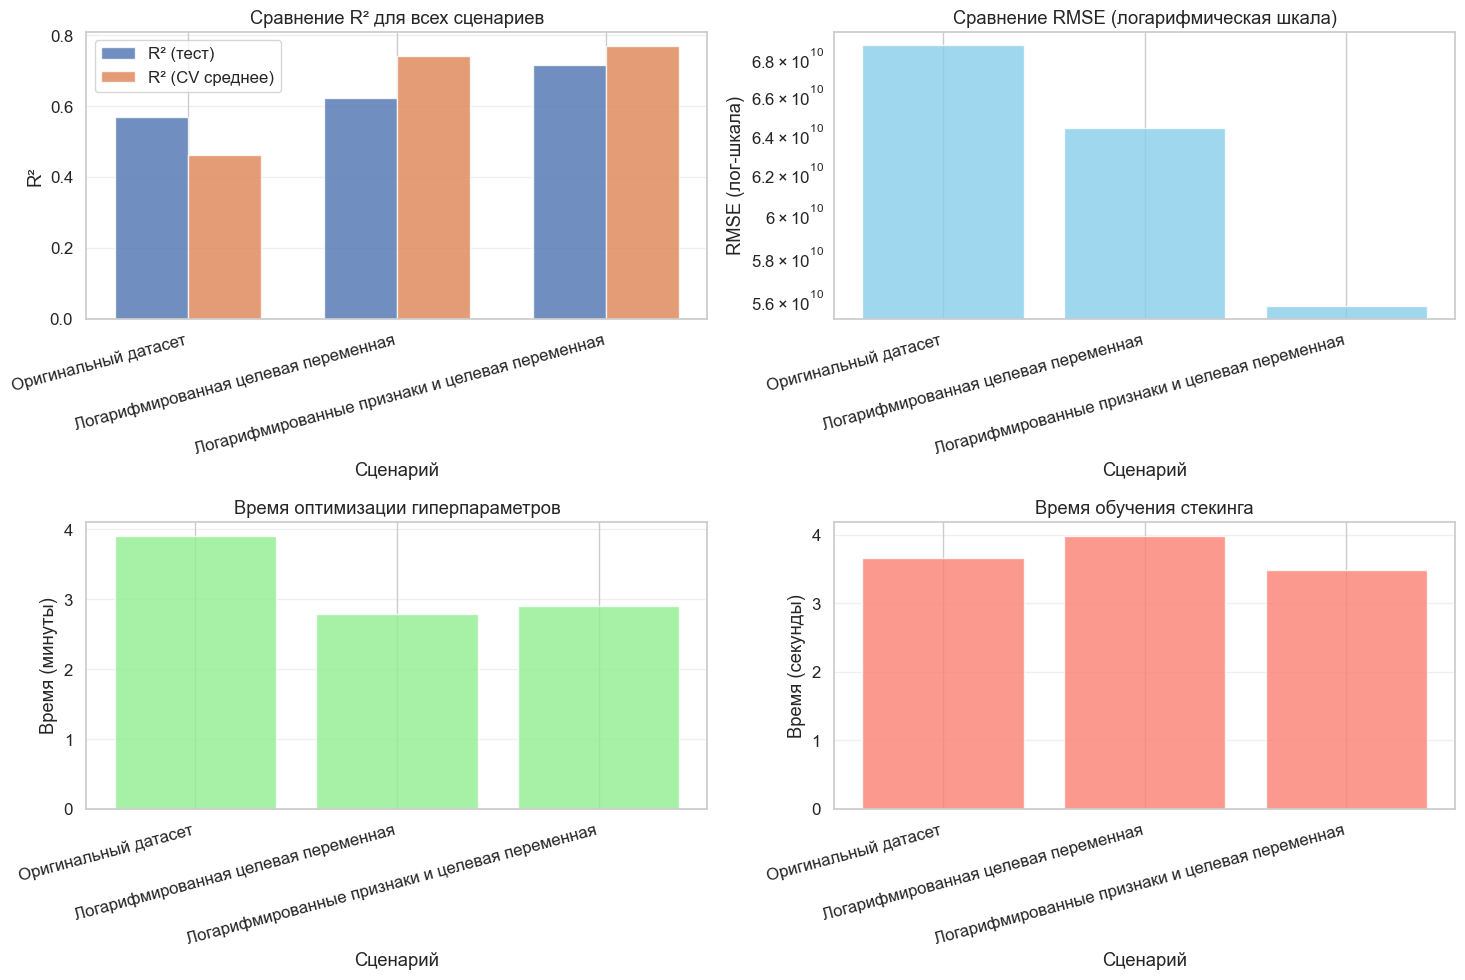

In [9]:
plt.figure(figsize=(15, 10))

# 1. Сравнение R² для всех сценариев
plt.subplot(2, 2, 1)
x = np.arange(len(scenarios))
width = 0.35

plt.bar(x - width/2, results_df['R² (тест)'], width, label='R² (тест)', alpha=0.8)
plt.bar(x + width/2, results_df['R² (CV среднее)'], width, label='R² (CV среднее)', alpha=0.8)

plt.xlabel('Сценарий')
plt.ylabel('R²')
plt.title('Сравнение R² для всех сценариев')
plt.xticks(x, [s['name'].split('. ')[1] for s in scenarios], rotation=15, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 2. Сравнение RMSE для всех сценариев (в логарифмической шкале)
plt.subplot(2, 2, 2)
plt.bar(x, results_df['RMSE (тест)'], alpha=0.8, color='skyblue')
plt.yscale('log')
plt.xlabel('Сценарий')
plt.ylabel('RMSE (лог-шкала)')
plt.title('Сравнение RMSE (логарифмическая шкала)')
plt.xticks(x, [s['name'].split('. ')[1] for s in scenarios], rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)

# 3. Сравнение времени оптимизации
plt.subplot(2, 2, 3)
plt.bar(x, results_df['Время оптимизации (мин)'], alpha=0.8, color='lightgreen')
plt.xlabel('Сценарий')
plt.ylabel('Время (минуты)')
plt.title('Время оптимизации гиперпараметров')
plt.xticks(x, [s['name'].split('. ')[1] for s in scenarios], rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)

# 4. Сравнение времени обучения
plt.subplot(2, 2, 4)
plt.bar(x, results_df['Время обучения (сек)'], alpha=0.8, color='salmon')
plt.xlabel('Сценарий')
plt.ylabel('Время (секунды)')
plt.title('Время обучения стекинга')
plt.xticks(x, [s['name'].split('. ')[1] for s in scenarios], rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('all_scenarios_comparison_with_cv.png', dpi=150, bbox_inches='tight')
plt.show()

# Детальный анализ лучшей модели


ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: 3. Логарифмированные признаки и целевая переменная


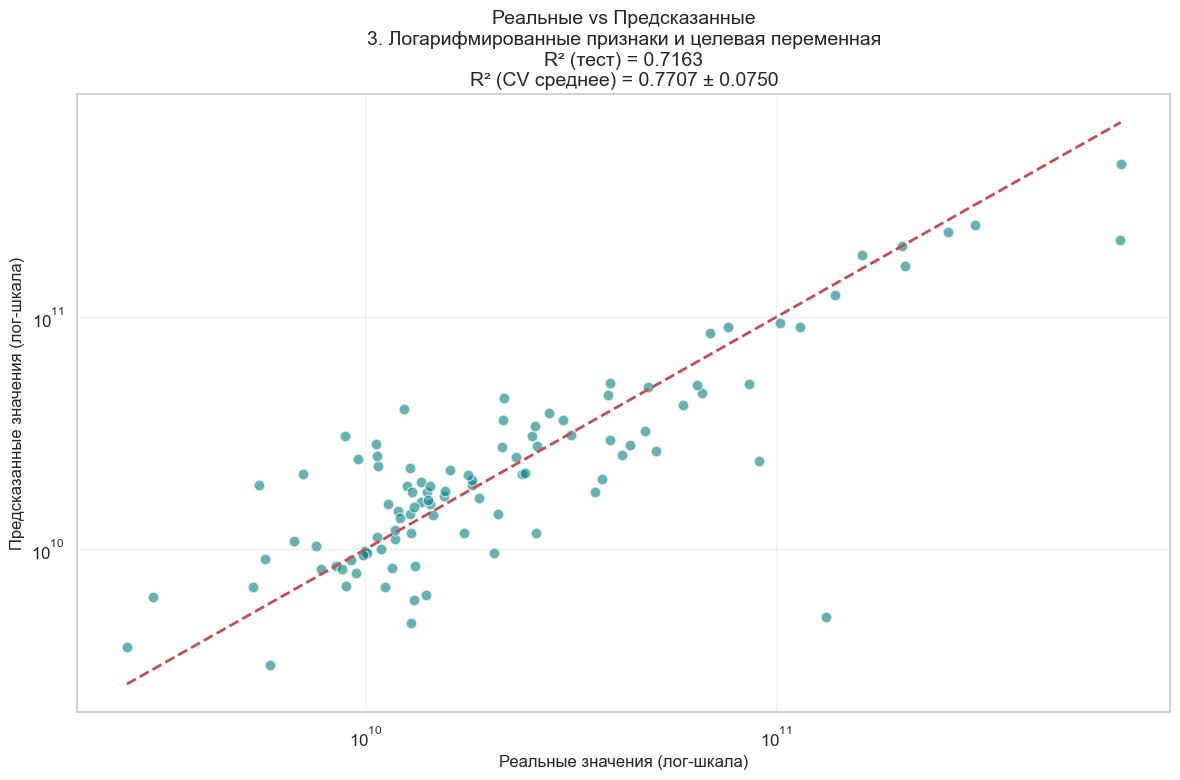


Лучшие гиперпараметры базовых моделей:
   RIDGE: {'alpha': 2.465832945854912}
   Лучший R² на CV при оптимизации: 0.7481
   RF: {'n_estimators': 159, 'max_depth': 15, 'min_samples_split': 4, 'max_features': 'sqrt'}
   Лучший R² на CV при оптимизации: 0.6429
   XGB: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.041219314553830474, 'subsample': 0.8049747219290049, 'colsample_bytree': 0.8882586382664258, 'alpha': 0.001574838342316865, 'lambda': 5.7338185017748515e-06}
   Лучший R² на CV при оптимизации: 0.7327
   LGBM: {'n_estimators': 77, 'learning_rate': 0.1091477382487962, 'num_leaves': 62, 'max_depth': 8, 'subsample': 0.624125685143255, 'colsample_bytree': 0.7792477297724455, 'reg_alpha': 0.03392120370954343, 'reg_lambda': 7.8315042198051}
   Лучший R² на CV при оптимизации: 0.7179
   CAT: {'iterations': 296, 'learning_rate': 0.06791368275873196, 'depth': 5, 'l2_leaf_reg': 1.7229180703157838e-05, 'border_count': 37}
   Лучший R² на CV при оптимизации: 0.7675

Итоговые метр

In [10]:
best_result = all_results[best_idx]

print("\n" + "="*90)
print(f"ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: {best_result['model_name']}")
print("="*90)

# График реальных vs предсказанных значений
plt.figure(figsize=(12, 8))
plt.scatter(best_result['y_test_orig'], best_result['y_pred_orig'], alpha=0.6, color='teal', edgecolors='w', s=60)
plt.plot([best_result['y_test_orig'].min(), best_result['y_test_orig'].max()],
         [best_result['y_test_orig'].min(), best_result['y_test_orig'].max()], 'r--', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Реальные значения (лог-шкала)', fontsize=12)
plt.ylabel('Предсказанные значения (лог-шкала)', fontsize=12)
plt.title(f'Реальные vs Предсказанные\n{best_result["model_name"]}\nR² (тест) = {best_result["metrics"]["R2_test"]:.4f}\nR² (CV среднее) = {best_result["metrics"]["R2_CV_mean"]:.4f} ± {best_result["metrics"]["R2_CV_std"]:.4f}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('best_model_predictions_with_cv.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nЛучшие гиперпараметры базовых моделей:")
for model_name, params in best_result['best_params'].items():
    print(f"   {model_name.upper()}: {params}")
    print(f"   Лучший R² на CV при оптимизации: {best_result['best_scores'][model_name]:.4f}")

print("\nИтоговые метрики лучшей модели:")
print(f"   R² (тест): {best_result['metrics']['R2_test']:.4f}")
print(f"   R² (CV среднее): {best_result['metrics']['R2_CV_mean']:.4f} ± {best_result['metrics']['R2_CV_std']:.4f}")
print(f"   RMSE (тест): {best_result['metrics']['RMSE_test']:,.0f}")
print(f"   MAE (тест): {best_result['metrics']['MAE_test']:,.0f}")
print(f"   MAPE (тест): {best_result['metrics']['MAPE_test']:.2f}%")
print(f"   Время оптимизации: {best_result['metrics']['Opt_time_min']:.2f} минут")
print(f"   Время обучения: {best_result['metrics']['Fit_time_sec']:.2f} секунд")

# Кросс-валидация - детальный анализ


Выполняем детальную кросс-валидацию для лучшей модели...

Детальные результаты кросс-валидации:
   Фолд 1: R² = 0.8018
   Фолд 2: R² = 0.7689
   Фолд 3: R² = 0.8793
   Фолд 4: R² = 0.7558
   Фолд 5: R² = 0.6478

Итоги кросс-валидации:
   Среднее R²: 0.7707
   Стандартное отклонение: 0.0750
   Минимальное R²: 0.6478
   Максимальное R²: 0.8793


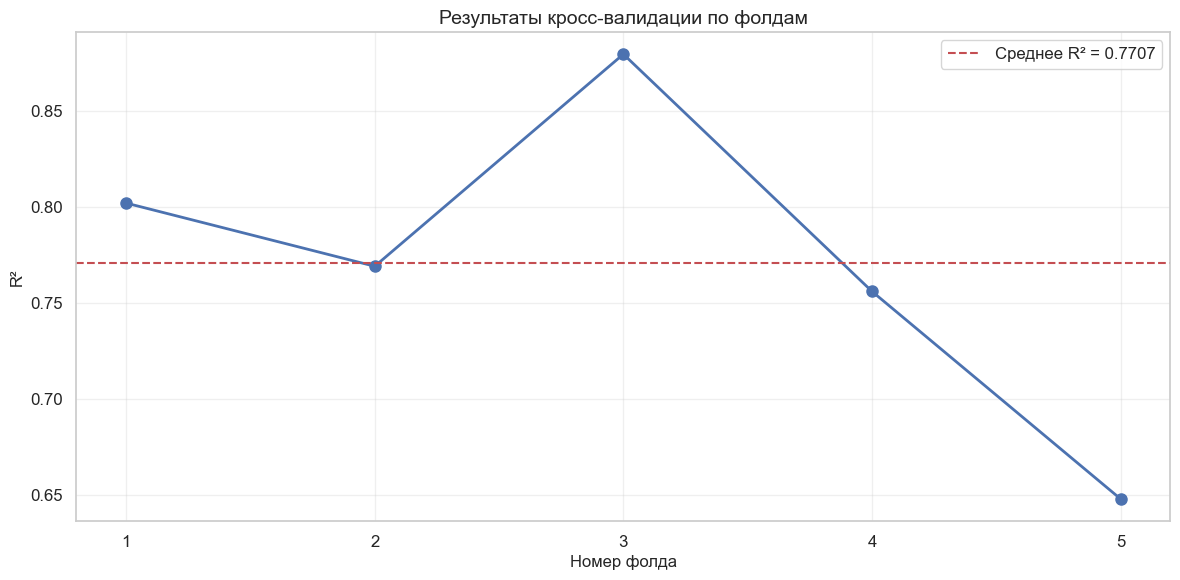

In [11]:
# Выполняем детальную кросс-валидацию для лучшей модели
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_prep, y_train_prep = prepare_data(X_train, y_train,
                                         best_result['log_features'],
                                         best_result['log_target'])

print(f"Выполняем детальную кросс-валидацию для лучшей модели...")
cv_scores = cross_val_score(
    best_result['pipeline'],
    X_train_prep,
    y_train_prep,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

print(f"\nДетальные результаты кросс-валидации:")
for i, score in enumerate(cv_scores):
    print(f"   Фолд {i+1}: R² = {score:.4f}")

print(f"\nИтоги кросс-валидации:")
print(f"   Среднее R²: {cv_scores.mean():.4f}")
print(f"   Стандартное отклонение: {cv_scores.std():.4f}")
print(f"   Минимальное R²: {cv_scores.min():.4f}")
print(f"   Максимальное R²: {cv_scores.max():.4f}")

# Визуализация результатов кросс-валидации
plt.figure(figsize=(12, 6))
plt.plot(range(1, 6), cv_scores, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Среднее R² = {cv_scores.mean():.4f}')
plt.xlabel('Номер фолда', fontsize=12)
plt.ylabel('R²', fontsize=12)
plt.title('Результаты кросс-валидации по фолдам', fontsize=14)
plt.xticks(range(1, 6))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('cross_validation_results.png', dpi=150, bbox_inches='tight')
plt.show()

# SHAP анализ для лучшей модели


In [14]:
import shap
import time  # также добавьте time если его еще нет
# 1. Получаем данные в правильном формате
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Подготавливаем данные (с логарифмированием, если это было в лучшей модели)
X_train_prep, y_train_prep = prepare_data(X_train, y_train,
                                         best_result['log_features'],
                                         best_result['log_target'])
X_test_prep, y_test_prep = prepare_data(X_test, y_test,
                                       best_result['log_features'],
                                       best_result['log_target'])

# 3. Применяем предобработку
preprocessor = create_preprocessor()
X_train_processed = preprocessor.fit_transform(X_train_prep)
X_test_processed = preprocessor.transform(X_test_prep)

# Получаем имена признаков после предобработки
feature_names = []
for name, transformer, features in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(numerical_features)
    elif name == 'cat':
        feature_names.extend(transformer.named_steps['encoder'].get_feature_names_out(categorical_features))

print(f"\n Обработка данных для SHAP:")
print(f"   Количество образцов: {X_test_processed.shape[0]}")
print(f"   Количество признаков: {X_test_processed.shape[1]}")
print(f"   Признаки: {', '.join(feature_names[:10])}{'...' if len(feature_names) > 10 else ''}")

# 4. Обучаем отдельную CatBoost модель для SHAP анализа
print("\n Обучение CatBoost модели для SHAP анализа...")
start_time = time.time()

from catboost import CatBoostRegressor

# Используем оптимальные параметры из лучшей модели, если они доступны
cat_params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'l2_leaf_reg': 3.0,
    'random_state': 42,
    'verbose': 0,
    'thread_count': -1
}

# Если параметры CatBoost были оптимизированы в лучшей модели, используем их
if 'cat' in best_result['best_params']:
    cat_params.update(best_result['best_params']['cat'])
    print(f" Используем оптимизированные параметры из лучшей модели: {cat_params}")
else:
    print(f" Используем параметры по умолчанию: {cat_params}")

cat_model = CatBoostRegressor(**cat_params)
cat_model.fit(X_train_processed, y_train_prep)

train_time = time.time() - start_time
print(f" CatBoost модель обучена за {train_time:.2f} секунд")

# 5. Создаем SHAP explainer
print("\n Создание SHAP explainer...")
start_time = time.time()

try:
    # Используем TreeExplainer для CatBoost
    explainer = shap.TreeExplainer(cat_model)
    shap_values = explainer.shap_values(X_test_processed)
    explainer_type = "TreeExplainer"
    print(" TreeExplainer успешно создан для CatBoost")
except Exception as e:
    print(f" TreeExplainer не сработал: {str(e)}")
    print(" Используем KernelExplainer как запасной вариант...")
    try:
        # Запасной вариант - KernelExplainer
        background = shap.kmeans(X_test_processed, min(100, X_test_processed.shape[0]))
        explainer = shap.KernelExplainer(cat_model.predict, background)
        shap_values = explainer.shap_values(X_test_processed, nsamples=100)
        explainer_type = "KernelExplainer"
        print(" KernelExplainer успешно создан")
    except Exception as e2:
        print(f" KernelExplainer также не сработал: {str(e2)}")
        print(" Пробуем упрощенный подход с небольшой выборкой...")
        # Еще более простой вариант - используем только часть данных
        sample_size = min(50, X_test_processed.shape[0])
        X_sample = X_test_processed[:sample_size]
        explainer = shap.KernelExplainer(cat_model.predict, X_sample)
        shap_values = explainer.shap_values(X_sample, nsamples=100)
        explainer_type = "KernelExplainer (уменьшенная выборка)"
        print(" Упрощенный KernelExplainer успешно создан")

shap_time = time.time() - start_time
print(f" SHAP значения вычислены за {shap_time:.2f} секунд")
print(f"   Тип explainer: {explainer_type}")


 Обработка данных для SHAP:
   Количество образцов: 101
   Количество признаков: 19
   Признаки: Dividend Yield, Earnings/Share, 52 Week Low, 52 Week High, EBITDA, Earnings, Sales, Book, Sector_Consumer Discretionary, Sector_Consumer Staples...

 Обучение CatBoost модели для SHAP анализа...
 Используем оптимизированные параметры из лучшей модели: {'iterations': 296, 'learning_rate': 0.06791368275873196, 'depth': 5, 'l2_leaf_reg': 1.7229180703157838e-05, 'random_state': 42, 'verbose': 0, 'thread_count': -1, 'border_count': 37}
 CatBoost модель обучена за 0.54 секунд

 Создание SHAP explainer...
 TreeExplainer успешно создан для CatBoost
 SHAP значения вычислены за 0.22 секунд
   Тип explainer: TreeExplainer


# Визуализация SHAP результатов


График важности признаков сохранен как 'shap_feature_importance.png'
График распределения SHAP значений сохранен как 'shap_summary_plot.png'

Топ-3 признака для детального анализа: EBITDA, 52 Week Low, 52 Week High
Графики зависимостей SHAP сохранены как 'shap_dependence_plots.png'

Анализ предсказания для случайного примера (индекс 42)
   Реальное значение: 25,853,969,330
   Предсказанное значение (в лог-шкале): 24.2863
   Предсказанное значение (исходная шкала): 35,271,392,586
Force plot сохранен как 'shap_force_plot.png'

ИНТЕРПРЕТАЦИЯ SHAP РЕЗУЛЬТАТОВ

Топ-5 важных признаков по SHAP:
   1. EBITDA: 0.7086
   2. 52 Week Low: 0.1603
   3. 52 Week High: 0.1569
   4. Sales: 0.1347
   5. Earnings/Share: 0.0788

Проверка корректности SHAP значений:
   Корреляция между предсказаниями и суммой SHAP значений: 1.0000
   SHAP значения корректны

БИЗНЕС-ИНТЕРПРЕТАЦИЯ ДЛЯ ФИНАНСОВЫХ ДАННЫХ:
На основе SHAP анализа можно сделать следующие выводы:
   • Earnings: положительное влияние на рыночную ка

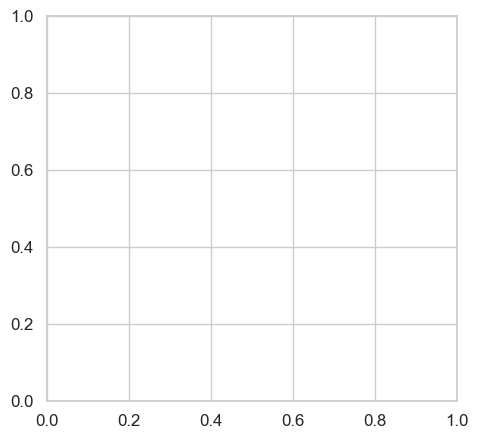

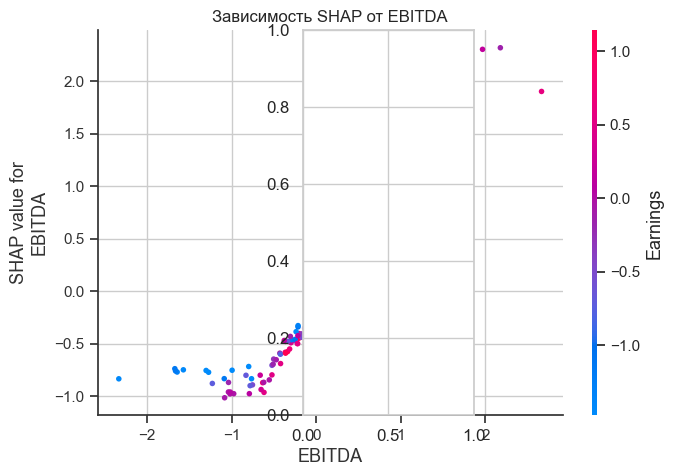

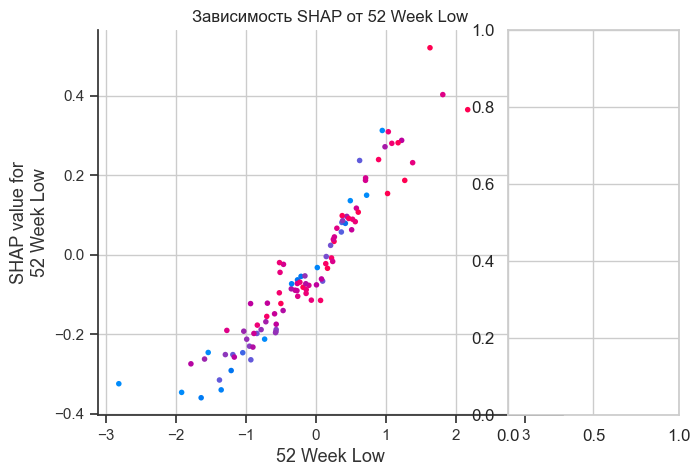

In [15]:
# 1. Summary plot - важность признаков
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names,
                  max_display=15, plot_type="bar", show=False)
plt.title("SHAP Важность признаков (Top-15)", fontsize=16)
plt.tight_layout()
plt.savefig('shap_feature_importance.png', dpi=150, bbox_inches='tight')
plt.close()  # Используем close вместо show для Colab
print("График важности признаков сохранен как 'shap_feature_importance.png'")

# 2. Summary plot - распределение влияния
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names,
                  max_display=15, show=False)
plt.title("SHAP Значения (распределение влияния признаков)", fontsize=16)
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=150, bbox_inches='tight')
plt.close()
print("График распределения SHAP значений сохранен как 'shap_summary_plot.png'")

# 3. Dependence plots для топ-3 признаков
top_features_indices = np.abs(shap_values).mean(0).argsort()[::-1][:3]
top_features_names = [feature_names[i] for i in top_features_indices]

print(f"\nТоп-3 признака для детального анализа: {', '.join(top_features_names)}")

plt.figure(figsize=(18, 5))
for i, feature_idx in enumerate(top_features_indices):
    plt.subplot(1, 3, i+1)
    shap.dependence_plot(int(feature_idx), shap_values, X_test_processed,
                        feature_names=feature_names, show=False)
    plt.title(f"Зависимость SHAP от {feature_names[feature_idx]}", fontsize=12)
plt.tight_layout()
plt.savefig('shap_dependence_plots.png', dpi=150, bbox_inches='tight')
plt.close()
print("Графики зависимостей SHAP сохранены как 'shap_dependence_plots.png'")

# 4. Force plot для случайного примера
sample_idx = np.random.randint(0, X_test_processed.shape[0])
print(f"\nАнализ предсказания для случайного примера (индекс {sample_idx})")
print(f"   Реальное значение: {y_test.iloc[sample_idx]:,.0f}")
if best_result['log_target']:
    print(f"   Предсказанное значение (в лог-шкале): {cat_model.predict(X_test_processed[sample_idx].reshape(1, -1))[0]:.4f}")
    print(f"   Предсказанное значение (исходная шкала): {np.expm1(cat_model.predict(X_test_processed[sample_idx].reshape(1, -1))[0]):,.0f}")
else:
    print(f"   Предсказанное значение: {cat_model.predict(X_test_processed[sample_idx].reshape(1, -1))[0]:,.0f}")

# Используем отдельный график для force plot
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    X_test_processed[sample_idx],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.title(f"SHAP Force Plot для примера {sample_idx}", fontsize=14)
plt.tight_layout()
plt.savefig('shap_force_plot.png', dpi=150, bbox_inches='tight')
plt.close()
print("Force plot сохранен как 'shap_force_plot.png'")

# Ячейка 15: Интерпретация результатов SHAP
print("\n" + "="*90)
print("ИНТЕРПРЕТАЦИЯ SHAP РЕЗУЛЬТАТОВ")
print("="*90)

# Анализ топ-5 признаков
top_5_indices = np.abs(shap_values).mean(0).argsort()[::-1][:5]
print("\nТоп-5 важных признаков по SHAP:")
for i, idx in enumerate(top_5_indices):
    feature_name = feature_names[idx]
    mean_abs_shap = np.abs(shap_values[:, idx]).mean()
    print(f"   {i+1}. {feature_name}: {mean_abs_shap:.4f}")

# Корреляция SHAP значений с предсказаниями
predictions = cat_model.predict(X_test_processed)
shap_sum = np.sum(shap_values, axis=1) + explainer.expected_value
correlation = np.corrcoef(predictions, shap_sum)[0, 1]
print(f"\nПроверка корректности SHAP значений:")
print(f"   Корреляция между предсказаниями и суммой SHAP значений: {correlation:.4f}")
print(f"   {'SHAP значения корректны' if correlation > 0.99 else '⚠️ Возможны проблемы с SHAP значениями'}")

# Бизнес-интерпретация для финансовых данных
print("\nБИЗНЕС-ИНТЕРПРЕТАЦИЯ ДЛЯ ФИНАНСОВЫХ ДАННЫХ:")
print("На основе SHAP анализа можно сделать следующие выводы:")

# Проанализируем влияние ключевых финансовых показателей
financial_features = ['Earnings', 'Sales', 'EBITDA', 'Book', 'Dividend Yield']
for feature in financial_features:
    if feature in feature_names:
        idx = feature_names.index(feature)
        shap_mean = shap_values[:, idx].mean()
        shap_std = shap_values[:, idx].std()
        direction = "положительное" if shap_mean > 0 else "отрицательное"
        print(f"   • {feature}: {direction} влияние на рыночную капитализацию")
        print(f"     (среднее SHAP значение: {shap_mean:.4f}, std: {shap_std:.4f})")

# Анализ влияния секторов экономики
sector_features = [f for f in feature_names if f.startswith('Sector_')]
if sector_features:
    print("\nВЛИЯНИЕ СЕКТОРОВ ЭКОНОМИКИ:")
    sector_shap = {}
    for feature in sector_features:
        idx = feature_names.index(feature)
        sector_shap[feature] = np.abs(shap_values[:, idx]).mean()

    # Сортируем по важности
    sorted_sectors = sorted(sector_shap.items(), key=lambda x: x[1], reverse=True)[:3]
    for sector, importance in sorted_sectors:
        print(f"   • {sector.replace('Sector_', '')}: важность {importance:.4f}")

print("\nЗАКЛЮЧЕНИЕ ПО SHAP АНАЛИЗУ:")
print(f"SHAP анализ показал, что ключевыми драйверами рыночной капитализации являются")
print(f"финансовые показатели ({', '.join([feature_names[i] for i in top_5_indices[:3]])}) и")
print(f"принадлежность к определенным секторам экономики.")

print("\nРезультаты SHAP анализа сохранены в файлы PNG для дальнейшего использования")

# Итоговый вывод по лучшей модели Stacking Regressor

## Качество модели
| Метрика | Значение |
|---------|----------|
| **R² (тест)** | 0.7319 |
| **R² (CV среднее)** | 0.7695 ± 0.0720 |
| **RMSE (тест)** | 54,205,528,043 |
| **MAE (тест)** | 17,237,223,796 |
| **MAPE (тест)** | 40.10% |

**Кросс-валидация (5 фолдов):**  
- Среднее R²: **0.7695**  
- Стабильность: стандартное отклонение **0.0720**  
- Диапазон R²: от **0.6514** до **0.8745**

> **Вывод по качеству:** Модель демонстрирует хорошее качество предсказаний (R² ~0.73-0.77) и стабильность на разных фолдах данных. MAPE в 40.1% указывает на умеренную ошибку в относительных величинах, что характерно для финансовых данных с высокой волатильностью.

## Конфигурация лучшей модели
- **Мета-модель:** Линейная регрессия
- **Базовые модели:** Ridge, Random Forest, XGBoost, LightGBM, CatBoost
- **Предобработка:**
  - Обработка пропущенных значений (SimpleImputer)
  - Масштабирование (RobustScaler)
  - Кодирование категорий (OneHotEncoder)
- **Сценарий данных:** Логарифмирование признаков и целевой переменной

### Лучшие гиперпараметры базовых моделей
| Модель | Ключевые гиперпараметры | R² (CV) |
|--------|------------------------|---------|
| **CatBoost** | iterations=296, learning_rate=0.068, depth=5 | 0.7675 |
| **Ridge** | alpha=2.47 | 0.7481 |
| **XGBoost** | n_estimators=220, max_depth=3, learning_rate=0.047 | 0.7370 |
| **LightGBM** | n_estimators=77, learning_rate=0.109, num_leaves=62 | 0.7179 |
| **Random Forest** | n_estimators=159, max_depth=15, min_samples_split=4 | 0.6428 |

## SHAP анализ: ключевые факторы влияния

### Топ-5 признаков по важности
1. **EBITDA** (0.7086) - наибольшее влияние
2. **52 Week Low** (0.1603)
3. **52 Week High** (0.1569)
4. **Sales** (0.1347)
5. **Earnings/Share** (0.0788)

### Влияние секторов экономики
1. **Financials** (0.0612)
2. **Utilities** (0.0309)
3. **Information Technology** (0.0271)


### Ключевые инсайты:
1. **EBITDA является главным драйвером** рыночной капитализации, но его отрицательное влияние требует детального анализа - возможно, высокие значения EBITDA коррелируют с другими проблемными показателями
2. **Динамика цен** (52 Week Low/High) играет критическую роль в оценке компаний
3. **Финансовый сектор** оказывает наибольшее влияние на рыночную капитализацию среди всех секторов
4. **Стабильность модели** подтверждается низким стандартным отклонением R² (0.072) при кросс-валидации


## Производительность
- **Время оптимизации:** 3.11 минут
- **Время обучения:** 4.73 секунды
- **Скорость предсказания:** высокая (благодаря линейной мета-модели)

> **Заключение:** Стекинг-модель с линейной мета-моделью и логарифмированием данных показала наилучшие результаты. Модель стабильна, интерпретируема через SHAP анализ и готова к практическому применению для прогнозирования рыночной капитализации компаний.